In [1]:
import sys, os, re; sys.path = (["../src/", "../"] if re.match(r'^(\w\:\\)|(/)', os.getcwd()) else [])+ sys.path 
from typing import Any, Optional, List

import qubx
%qubxd dev 

%load_ext autoreload
%autoreload 2

from qubx import lookup, logger
from qubx.pandaz.utils import *

# - - - - - - - - - - - - - - - - - - - - - - - -
from qubx.data.readers import CsvStorageDataReader, MultiQdbConnector, AsTimestampedRecords, AsQuotes, RestoreTicksFromOHLC, AsPandasFrame, RestoreTicksFromOHLC, AsOhlcvSeries
from qubx.core.basics import Deal, Instrument, Order, Position, Signal
from qubx.utils.charting.lookinglass import LookingGlass
from qubx.core.utils import recognize_time, time_to_str

from qubx.backtester.simulator import simulate
from qubx.core.metrics import tearsheet, chart_signals, portfolio_metrics
from qubx.trackers.riskctrl import StopTakePositionTracker
from qubx.trackers.sizers import FixedSizer, FixedRiskSizer, FixedLeverageSizer

 >  [dev] installing cython rebuilding hook

⠀⠀⡰⡖⠒⠒⢒⢦⠀⠀   
⠀⢠⠃⠈⢆⣀⣎⣀⣱⡀  QUBX | Quantitative Backtesting Environment 
⠀⢳⠒⠒⡞⠚⡄⠀⡰⠁         (c) 2024, ver. Dev
⠀⠀⠱⣜⣀⣀⣈⣦⠃⠀⠀⠀ 
        


# Issue 1

In [2]:
signals = pd.read_csv("../tests/data/generated_signals.csv", index_col="timestamp", parse_dates=True)
print(signals.index[0], '>--<', signals.index[-1])
exchange, symbol = "BINANCE.UM", "BTCUSDT"

2023-08-13 17:23:33.720000 >--< 2024-04-30 22:30:00.030000


In [67]:
reader = CsvStorageDataReader("../tests/data/csv")
ohlc = reader.read("BTCUSDT_ohlcv_M1", transform=AsPandasFrame())
assert (i1 := lookup.find_symbol(exchange, symbol)) is not None
S = pd.DataFrame( { i1: {
            pd.Timestamp("2024-01-10 15:08:59.716000"): 1,
            pd.Timestamp("2024-01-10 15:10:52.679000"): 1,
            pd.Timestamp("2024-01-10 15:32:44.798000"): 1,
            pd.Timestamp("2024-01-10 15:59:55.303000"): 1,
            pd.Timestamp("2024-01-10 16:09:00.970000"): 1,
            pd.Timestamp("2024-01-10 16:12:34.233000"): 1,
            pd.Timestamp("2024-01-10 19:04:00.905000"): 1,
            pd.Timestamp("2024-01-10 19:44:37.785000"): 1,
            pd.Timestamp("2024-01-10 20:06:00.322000"): 1,
        }}
)

In [68]:
# S = signals['2023-08-27 14:00':'2023-08-29 14:30']
# S = signals['2024-02-26 00:00':'2024-02-27 00:00']
rep = simulate({ 
        "liq_buy_bounces_c": [ S, StopTakePositionTracker(2.5, 0.5, FixedLeverageSizer(0.1), "client")],
        "liq_buy_bounces_b": [ S, StopTakePositionTracker(2.5, 0.5, FixedLeverageSizer(0.1), "broker")],
     }, {f"{exchange}:{symbol}" : ohlc}, 10000, [exchange + ":" + symbol], commissions="vip9_usdt", debug='DEBUG',  # type: ignore
    # start=S.index[0], stop=S.index[-1] + pd.Timedelta('5Min'), 
    open_close_time_indent_secs=1,
    start=S.index[0] - pd.Timedelta("5Min"), stop=S.index[-1] + pd.Timedelta("5Min"))

  0%|          | 0/2 [00:00<?, ?it/s]

2024-12-04 17:21:59.905 [ 🐞 ] (simulator) 2024-01-10 15:03:59.716000 Initiating simulated trading for binance.um for 10000 x 1.0 in USDT...
2024-01-10 15:03:59.716 [ℹ️] SimulatedExchange.binance.um is initialized
2024-01-10 15:03:59.716 [🐞] SignalsProxy new parameters:
	set timeframe <- 1Min
2024-01-10 15:03:59.716 [🐞] Using pre-generated signals:
 CRYPTO:BINANCE.UM:BTCUSDT    9

2024-01-10 15:03:59.716 [🐞]  | get_subscribed_instruments __all__ -> []
2024-01-10 15:03:59.716 [🐞]  | get_subscriptions None -> []


Simulating:   0%|          | 0/100 [00:00<?, ?%/s]

2024-01-10 15:03:59.716 [🐞]  | get_subscribed_instruments ohlc(1Min) -> []
2024-01-10 15:03:59.716 [🐞]  | get_subscribed_instruments None -> []
2024-01-10 15:03:59.716 [🐞]  | get_subscribed_instruments ohlc(1Min) -> []
2024-01-10 15:03:59.716 [🐞]  | subscribe: ohlc(1Min) -> {CRYPTO:BINANCE.UM:BTCUSDT}
2024-01-10 15:03:59.716 [ℹ️] SimulatedExchange ::: Simulation started at 2024-01-10 15:03:59.716000 :::
2024-01-10 15:03:59.716 [🐞] Preloading initial data for ohlc.1Min 2024-01-10 15:03:59.716000 : 2024-01-10 20:06:00.322000 ...
2024-01-10 15:03:59.716 [🐞] Preloading initial data for ohlc.1Min 2024-01-10 15:03:59.716000 : 2024-01-10 20:06:00.322000 ...
2024-01-10 15:04:59.000 [🐞] Invoking SignalsProxy on_fit
2024-01-10 15:04:59.000 [🐞] SignalsProxy is fitted
2024-01-10 15:09:01.000 [🐞] ClientSideRiskController new signal received: Target for SignalsProxy 45161.90 +1.000000 BTCUSDT stop: 44936.1 take: 46291.0 on BINANCE.UM [] -> 0.022 at 2024-01-10T15:09:01.000000000 for BTCUSDT take: 462

Simulating:   0%|          | 0/100 [00:00<?, ?%/s]

2024-01-10 15:03:59.716 [🐞]  | get_subscriptions None -> []
2024-01-10 15:03:59.716 [🐞]  | get_subscribed_instruments ohlc(1Min) -> []
2024-01-10 15:03:59.716 [🐞]  | get_subscribed_instruments None -> []
2024-01-10 15:03:59.716 [🐞]  | get_subscribed_instruments ohlc(1Min) -> []
2024-01-10 15:03:59.716 [🐞]  | subscribe: ohlc(1Min) -> {CRYPTO:BINANCE.UM:BTCUSDT}
2024-01-10 15:03:59.716 [ℹ️] SimulatedExchange ::: Simulation started at 2024-01-10 15:03:59.716000 :::
2024-01-10 15:03:59.716 [🐞] Preloading initial data for ohlc.1Min 2024-01-10 15:03:59.716000 : 2024-01-10 20:06:00.322000 ...
2024-01-10 15:03:59.716 [🐞] Preloading initial data for ohlc.1Min 2024-01-10 15:03:59.716000 : 2024-01-10 20:06:00.322000 ...
2024-01-10 15:04:59.000 [🐞] Invoking SignalsProxy on_fit
2024-01-10 15:04:59.000 [🐞] SignalsProxy is fitted
2024-01-10 15:09:01.000 [🐞] BrokerSideRiskController new signal received: Target for SignalsProxy 45161.90 +1.000000 BTCUSDT stop: 44936.1 take: 46291.0 on BINANCE.UM [] -> 

2024-01-10 19:44:59.000 [🐞] Executed 0.021 @ 46264.850000000006 of CRYPTO:BINANCE.UM:BTCUSDT for order SIM-ORDER-BTCUSDT-100007
2024-01-10 19:44:59.000 [🐞] BTCUSDT: Adjusting position from 0.0 to 0.021 : [SIM-ORDER-BTCUSDT-100007] MARKET BUY 0.021 of BTCUSDT  (gtc) [CLOSED]
2024-01-10 20:06:01.000 [🐞] BrokerSideRiskController new signal received: Target for SignalsProxy 46337.20 +1.000000 BTCUSDT stop: 46105.5 take: 47495.6 on BINANCE.UM [] -> 0.021 at 2024-01-10T20:06:01.000000000 for BTCUSDT take: 47495.6 stop: 46105.5
2024-01-10 20:06:01.000 [🐞] BINANCE.UM:BTCUSDT: Unable change position from 0.021 to 0.021 : too small difference
2024-01-10 20:06:59.000 [ℹ️] SimulatedExchange ::: Simulation finished at 2024-01-10 20:06:00.322000 :::


In [69]:
scols(rep[0].executions_log, rep[1].executions_log).fillna(' ')

,instrument_id,exchange_id,side,filled_qty,price,commissions,commissions_quoted,instrument_id,exchange_id,side,filled_qty,price,commissions,commissions_quoted
timestamp,,,,,,,,,,,,,,
2024-01-10 15:09:01,BTCUSDT,BINANCE.UM,buy,0.022,45161.95,0.168906,USDT,BTCUSDT,BINANCE.UM,buy,0.022,45161.95,0.168906,USDT
2024-01-10 17:44:36,,,,,,,,BTCUSDT,BINANCE.UM,sell,-0.022,46291.0,0.0,USDT
2024-01-10 17:44:59,BTCUSDT,BINANCE.UM,sell,-0.022,46299.45,0.17316,USDT,,,,,,,
2024-01-10 19:04:01,BTCUSDT,BINANCE.UM,buy,0.021,46493.95,0.165983,USDT,BTCUSDT,BINANCE.UM,buy,0.021,46493.95,0.165983,USDT
2024-01-10 19:08:36,,,,,,,,BTCUSDT,BINANCE.UM,sell,-0.021,46261.4,0.165153,USDT
2024-01-10 19:08:59,BTCUSDT,BINANCE.UM,sell,-0.021,46219.95,0.165005,USDT,,,,,,,
2024-01-10 19:44:59,BTCUSDT,BINANCE.UM,buy,0.021,46264.85,0.165166,USDT,BTCUSDT,BINANCE.UM,buy,0.021,46264.85,0.165166,USDT


In [70]:
rep[0].signals_log

,instrument_id,exchange_id,signal,target_position,reference_price,price,take,stop,group,comment,service
timestamp,,,,,,,,,,,
2024-01-10 15:09:01,BTCUSDT,BINANCE.UM,1,0.022,45161.9,None,46291.0,44936.1,SignalsProxy,,False
2024-01-10 15:10:59,BTCUSDT,BINANCE.UM,1,0.022,45264.1,None,46395.7,45037.8,SignalsProxy,,False
2024-01-10 15:32:59,BTCUSDT,BINANCE.UM,1,0.022,45284.7,None,46416.8,45058.3,SignalsProxy,,False
2024-01-10 15:59:59,BTCUSDT,BINANCE.UM,1,0.021,45569.0,None,46708.2,45341.2,SignalsProxy,,False
2024-01-10 16:09:01,BTCUSDT,BINANCE.UM,1,0.022,45369.9,None,46504.2,45143.1,SignalsProxy,,False
2024-01-10 16:12:36,BTCUSDT,BINANCE.UM,1,0.022,45436.9,None,46572.8,45209.7,SignalsProxy,,False
2024-01-10 17:44:59,BTCUSDT,BINANCE.UM,0,0.000,NaN,None,NaN,NaN,Risk Manager,Take triggered,False
2024-01-10 19:04:01,BTCUSDT,BINANCE.UM,1,0.021,46493.9,None,47656.3,46261.4,SignalsProxy,,False
2024-01-10 19:08:59,BTCUSDT,BINANCE.UM,0,0.000,NaN,None,NaN,NaN,Risk Manager,Stop triggered,False


In [71]:
rep[1].signals_log

,instrument_id,exchange_id,signal,target_position,reference_price,price,take,stop,group,comment,service
timestamp,,,,,,,,,,,
2024-01-10 15:09:01,BTCUSDT,BINANCE.UM,1,0.022,45161.9,NaN,46291.0,44936.1,SignalsProxy,,False
2024-01-10 15:10:59,BTCUSDT,BINANCE.UM,1,0.022,45264.1,NaN,46395.7,45037.8,SignalsProxy,,False
2024-01-10 15:32:59,BTCUSDT,BINANCE.UM,1,0.022,45284.7,NaN,46416.8,45058.3,SignalsProxy,,False
2024-01-10 15:59:59,BTCUSDT,BINANCE.UM,1,0.021,45569.0,NaN,46708.2,45341.2,SignalsProxy,,False
2024-01-10 16:09:01,BTCUSDT,BINANCE.UM,1,0.022,45369.9,NaN,46504.2,45143.1,SignalsProxy,,False
2024-01-10 16:12:36,BTCUSDT,BINANCE.UM,1,0.022,45436.9,NaN,46572.8,45209.7,SignalsProxy,,False
2024-01-10 17:44:59,BTCUSDT,BINANCE.UM,0,0.000,NaN,46291.0,NaN,NaN,Risk Manager,Take triggered,True
2024-01-10 19:04:01,BTCUSDT,BINANCE.UM,1,0.021,46493.9,NaN,47656.3,46261.4,SignalsProxy,,False
2024-01-10 19:08:59,BTCUSDT,BINANCE.UM,0,0.000,NaN,46261.4,NaN,NaN,Risk Manager,Stop triggered,True


In [72]:
chart_signals(rep[0], symbol, ohlc, '1Min',  show_signals=True, height=500)

In [73]:
chart_signals(rep[1], symbol, ohlc, '1Min',  show_signals=True, height=500)

,,Gain,Cagr,Sharpe,Qr,Max dd pct,Mdd usd,Sortino,Calmar,Tail ratio,Stability,Var,Avg return,Fees,Execs
id,,,,,,,,,,,,,,,
0,/liq_buy_bounces_c,21.820130,1.215697,0.0,2.105419,0.082095,8.231421,0.0,0.0,1.0,0.0,0.0,0.218201,0.838220,5.0
1,/liq_buy_bounces_b,22.677692,1.285989,0.0,2.308597,0.073416,7.361119,0.0,0.0,1.0,0.0,0.0,0.226777,0.665208,5.0


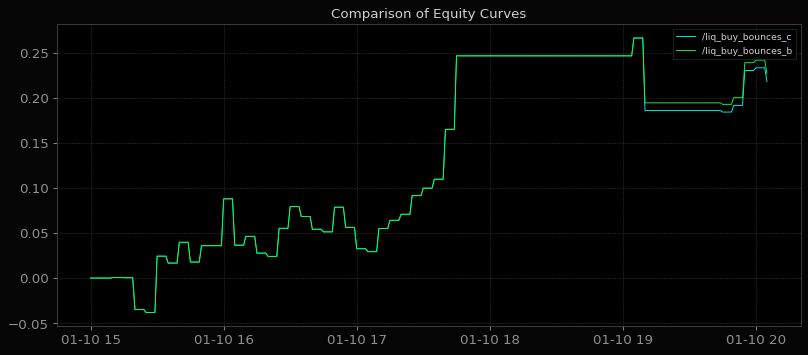

In [74]:
tearsheet(rep)

In [75]:
mtrx0 = portfolio_metrics(rep[0].portfolio_log, rep[0].executions_log, rep[1].capital, account_transactions=False, commission_factor=1)
mtrx1 = portfolio_metrics(rep[1].portfolio_log, rep[1].executions_log, rep[1].capital, account_transactions=False, commission_factor=1)
mtrx0['gain'], mtrx1['gain']

(22.6583499999997, 23.342899999999645)

# Issue 2

In [52]:
%load_ext autoreload
%autoreload 2

from qubx.trackers.riskctrl import StopTakePositionTracker
from qubx.trackers.sizers import FixedLeverageSizer

qdb = MultiQdbConnector('xlydian-data')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
signals = pd.read_csv("../tests/data/signals_issue.csv", index_col="timestamp", parse_dates=True)
signals

,BTCUSDT
timestamp,
2024-01-30 12:29:59.036,1
2024-01-30 13:16:35.910,1
2024-01-30 23:15:40.180,1
2024-01-30 23:29:00.270,1
2024-01-31 10:50:31.171,1
2024-01-31 20:02:58.573,1
2024-01-31 20:07:46.123,1
2024-01-31 21:25:58.912,1


In [54]:
rep = simulate(
    { 
        "liq_buy_bounces1": [signals, StopTakePositionTracker(2.5, 0.5, FixedLeverageSizer(0.1), "broker")], 
        "liq_buy_bounces2": [signals, StopTakePositionTracker(2.5, 0.5, FixedLeverageSizer(0.1), "client")], 
    },
    qdb, 10000, ["BINANCE.UM:BTCUSDT"], dict(type="ohlc", timeframe="1Min", nback=0), "1Min -1Sec", "vip9_usdt", 
    "2024-01-29", "2024-05-01", debug='DEBUG'
)

  0%|          | 0/2 [00:00<?, ?it/s]

2024-09-10 09:33:47.073 [ 🐞 ] 2024-01-29 00:00:00 Initiating simulated trading for binance.um for 10000 x 1.0 in USDT...
2024-01-29 00:00:00.000 [ℹ️] SimulatedData.binance.um initialized


Simulating:   0%|          | 0/249958.912 [00:00<?, ?s/s]

2024-01-29 00:00:00.000 [🐞] Using pre-generated signals:
 BTCUSDT    8

2024-01-29 00:00:00.000 [🐞] Triggering strategy on every 1Min bar after 
2024-01-29 00:00:00.000 [🐞] (StrategyContext) Subscribing to ohlc updates using {'timeframe': '1Min', 'nback': 0} for 
	['BTCUSDT'] 
2024-01-29 00:00:00.000 [🐞] SimulatedExchangeService :: subscribe :: BTCUSDT :: ohlc
2024-01-29 00:00:00.000 [ℹ️] SimulatedExchangeService :: run :: Simulation started at 2024-01-29
2024-01-29 00:00:00.000 [🐞] Initializing chunks for each loader
2024-01-29 00:00:00.000 [🐞] Initializing chunks for each loader
2024-01-29 00:00:00.001 [🐞] Invoking SignalsProxy on_fit('2024-01-29 00:00:00', 'None')
2024-01-29 00:00:00.001 [🐞] SignalsProxy is fitted
2024-01-30 12:29:59.999 [🐞] BrokerSideRiskController new signal received: Target for SignalsProxy 43392.90 +1.000000 BTCUSDT stop: 43175.985250000005 take: 44477.77375 on BINANCE.UM [] -> 0.023 at 2024-01-30T12:29:59.999000000 for BTCUSDT take: 44477.77375 stop: 43175.9852

Simulating:   0%|          | 0/249958.912 [00:00<?, ?s/s]

2024-01-29 00:00:00.000 [🐞] Triggering strategy on every 1Min bar after 
2024-01-29 00:00:00.000 [🐞] (StrategyContext) Subscribing to ohlc updates using {'timeframe': '1Min', 'nback': 0} for 
	['BTCUSDT'] 
2024-01-29 00:00:00.000 [🐞] SimulatedExchangeService :: subscribe :: BTCUSDT :: ohlc
2024-01-29 00:00:00.000 [ℹ️] SimulatedExchangeService :: run :: Simulation started at 2024-01-29
2024-01-29 00:00:00.000 [🐞] Initializing chunks for each loader
2024-01-29 00:00:00.000 [🐞] Initializing chunks for each loader
2024-01-29 00:00:00.001 [🐞] Invoking SignalsProxy on_fit('2024-01-29 00:00:00', 'None')
2024-01-29 00:00:00.001 [🐞] SignalsProxy is fitted
2024-01-30 12:29:59.999 [🐞] ClientSideRiskController new signal received: Target for SignalsProxy 43392.90 +1.000000 BTCUSDT stop: 43175.985250000005 take: 44477.77375 on BINANCE.UM [] -> 0.023 at 2024-01-30T12:29:59.999000000 for BTCUSDT take: 44477.77375 stop: 43175.985250000005
2024-01-30 12:29:59.999 [🐞] (StrategyContext) sending market bu

2024-01-31 21:25:59.999 [🐞] ClientSideRiskController -- starts tracking -- Target for SignalsProxy 42335.40 +1.000000 BTCUSDT stop: 42123.772750000004 take: 43393.83625 on BINANCE.UM [] -> 0.023 at 2024-01-31T21:25:59.999000000 of BTCUSDT take: 43393.83625 stop: 42123.772750000004
2024-01-31 21:25:59.999 [🐞] Executed 0.023 @ 42335.450000000004 of BTCUSDT for order SIM-ORDER-BTCUSDT-100013
2024-01-31 21:25:59.999 [🐞] BTCUSDT: Adjusting position from 0.0 to 0.023 : [SIM-ORDER-BTCUSDT-100013] MARKET BUY 0.023 of BTCUSDT  (gtc) [CLOSED]
2024-01-31 21:25:59.999 [ℹ️] SimulatedExchangeService :: run :: Simulation finished at 2024-01-31 21:25:58.912000


,,Gain,Cagr,Sharpe,Qr,Max dd pct,Mdd usd,Sortino,Calmar,Tail ratio,Stability,Var,Avg return,Fees,Execs
id,,,,,,,,,,,,,,,
0,/liq_buy_bounces1,-2.202574,-0.026445,-0.936869,-0.079469,0.242185,24.234905,-1.820646,-16.631414,0.862851,0.016317,20.635286,-0.007269,1.846074,13.0
1,/liq_buy_bounces2,-4.451497,-0.052731,-1.723061,-0.130101,0.264670,26.483923,-3.172293,-28.474311,0.761031,0.052937,23.441510,-0.014751,2.015797,13.0


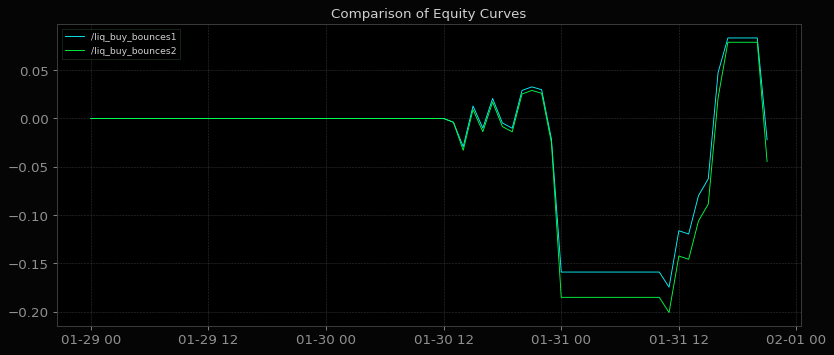

In [55]:
tearsheet(rep)

In [44]:
ohlc = {"BTCUSDT": qdb.read("BINANCE.UM:BTCUSDT", "2024-01-30", "2024-02-01", transform=AsPandasFrame())}

In [ ]:
chart_signals(rep[0], 'BTCUSDT', ohlc, '1Min',  show_signals=True)